In [3]:
# 📘 Loan Default Prediction: Lending Club Dataset

# 1. Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample

from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

# 2. Load Dataset
df = pd.read_csv("loans_full_schema.csv")

# 3. Drop High-Null Columns
null_threshold = 0.5
df = df.loc[:, df.isnull().mean() < null_threshold]

# 4. Drop Irrelevant Columns
df.drop(columns=['Unnamed: 0', 'emp_title', 'issue_month', 'sub_grade'], inplace=True, errors='ignore')

# 5. Handle Remaining Missing Values
df = df.dropna()

# 6. Filter Target Labels (Binary Classification)
df = df[df['loan_status'].isin(['Current', 'Charged Off'])]
df['loan_status'] = df['loan_status'].map({'Charged Off': 1, 'Current': 0})  # 1 = Defaulted

# 7. Encode Categorical Features
cat_cols = df.select_dtypes(include='object').columns
df[cat_cols] = df[cat_cols].apply(LabelEncoder().fit_transform)



In [7]:
# 8. Feature Scaling
scaler = StandardScaler()
X = df.drop("loan_status", axis=1)
y = df["loan_status"]
X_scaled = scaler.fit_transform(X)



In [13]:
from collections import Counter

# Show class distribution
print("Before SMOTE:", Counter(y))

# Determine the number of samples in the minority class
minority_class = y.value_counts().idxmin()
minority_count = y.value_counts().min()

# Set k_neighbors to one less than minority class count
k = min(5, minority_count - 1)

# Apply SMOTE
smote = SMOTE(random_state=42, k_neighbors=k)
X_res, y_res = smote.fit_resample(X_scaled, y)

print("After SMOTE:", Counter(y_res))


Before SMOTE: Counter({0: 7264, 1: 5})
After SMOTE: Counter({0: 7264, 1: 7264})


In [15]:
# 10. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)


In [17]:
# 11. Train LightGBM Model
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)

# 12. Train SVM Model
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)


[LightGBM] [Info] Number of positive: 5806, number of negative: 5816
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9712
[LightGBM] [Info] Number of data points in the train set: 11622, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499570 -> initscore=-0.001721
[LightGBM] [Info] Start training from score -0.001721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

C:\Users\ST\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🔍 LightGBM Evaluation:
[[1447    1]
 [   0 1458]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1448
           1       1.00      1.00      1.00      1458

    accuracy                           1.00      2906
   macro avg       1.00      1.00      1.00      2906
weighted avg       1.00      1.00      1.00      2906


🔍 SVM Evaluation:
[[1448    0]
 [   0 1458]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1448
           1       1.00      1.00      1.00      1458

    accuracy                           1.00      2906
   macro avg       1.00      1.00      1.00      2906
weighted avg       1.00      1.00      1.00      2906



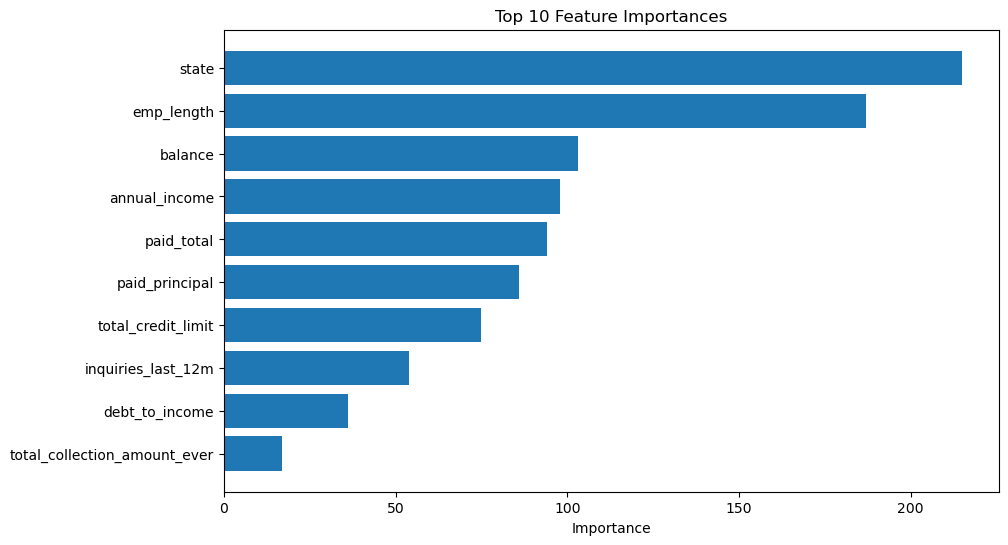

In [19]:
# 13. Evaluation Function
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n🔍 {model_name} Evaluation:")
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

# 14. Evaluate Models
evaluate_model(y_test, y_pred_lgbm, "LightGBM")
evaluate_model(y_test, y_pred_svm, "SVM")

# 15. Feature Importance (LightGBM)
importances = lgbm.feature_importances_
indices = np.argsort(importances)[-10:]
features = X.columns[indices]

plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances")
plt.barh(features, importances[indices])
plt.xlabel("Importance")
plt.show()

In [25]:
# Save training feature columns
feature_columns = X.columns
import joblib
joblib.dump(feature_columns, 'feature_columns.pkl')


['feature_columns.pkl']